<a href="https://colab.research.google.com/github/abubakerKhaled/Cars-Classification/blob/main/03_Inception_Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import random
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import StratifiedShuffleSplit
from google.colab import drive

drive.mount('/content/drive')
PROJECT_PATH = '/content/drive/MyDrive/StanfordCars_Project'
MODELS_PATH = os.path.join(PROJECT_PATH, 'models')
RESULTS_PATH = os.path.join(PROJECT_PATH, 'results')
DATA_PATH = os.path.join(PROJECT_PATH, 'stanford_cars_top20')

os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

if os.path.exists(DATA_PATH):
    print(f"Found data at: {DATA_PATH}")
    full_dataset = datasets.ImageFolder(root=DATA_PATH)
    targets = full_dataset.targets
    class_names = full_dataset.classes

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, val_idx = next(splitter.split(np.zeros(len(targets)), targets))

    class CustomDataset(Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform
        def __getitem__(self, index):
            x, y = self.subset[index]
            if self.transform: x = self.transform(x)
            return x, y
        def __len__(self):
            return len(self.subset)

    train_dataset = CustomDataset(Subset(full_dataset, train_idx), transform=train_transform)
    val_dataset = CustomDataset(Subset(full_dataset, val_idx), transform=val_transform)

    BATCH_SIZE = 32
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    print("Data Ready.")
else:
    print("Error: Check Data Path")

Mounted at /content/drive
Found data at: /content/drive/MyDrive/StanfordCars_Project/stanford_cars_top20
Data Ready.


In [ ]:

print("Downloading Inception V1 (GoogLeNet)...")


model_inception = models.googlenet(weights='IMAGENET1K_V1')


model_inception.aux_logits = False


for param in model_inception.parameters():
    param.requires_grad = False


num_ftrs = model_inception.fc.in_features
print(f"Original Input Features: {num_ftrs}")


num_classes = len(class_names)
model_inception.fc = nn.Linear(num_ftrs, num_classes)

print(f"Surgery Complete. Aux Heads disabled. New Head Output: {num_classes} classes.")

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 199MB/s]


Original Input Features: 1024
Surgery Complete. Aux Heads disabled. New Head Output: 20 classes.


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    since = time.time()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)


    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    print(f"Engine Start. Device: {device}")

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())


            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_inception.fc.parameters(), lr=0.001, momentum=0.9)


trained_inception, inception_history = train_model(
    model_inception,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=10
)

Engine Start. Device: cuda
Epoch 1/10
----------
train Loss: 3.0081 Acc: 0.0555
val Loss: 2.9438 Acc: 0.1211
Epoch 2/10
----------
train Loss: 2.9522 Acc: 0.1044
val Loss: 2.8825 Acc: 0.1579
Epoch 3/10
----------
train Loss: 2.8836 Acc: 0.1321
val Loss: 2.8262 Acc: 0.2053
Epoch 4/10
----------
train Loss: 2.8277 Acc: 0.1982
val Loss: 2.7730 Acc: 0.2579
Epoch 5/10
----------
train Loss: 2.7700 Acc: 0.2351
val Loss: 2.7223 Acc: 0.2789
Epoch 6/10
----------
train Loss: 2.7029 Acc: 0.2933
val Loss: 2.6729 Acc: 0.2737
Epoch 7/10
----------
train Loss: 2.6598 Acc: 0.3131
val Loss: 2.6298 Acc: 0.2947
Epoch 8/10
----------
train Loss: 2.6112 Acc: 0.3303
val Loss: 2.5840 Acc: 0.3316
Epoch 9/10
----------
train Loss: 2.5450 Acc: 0.3395
val Loss: 2.5396 Acc: 0.3526
Epoch 10/10
----------
train Loss: 2.5061 Acc: 0.4042
val Loss: 2.5044 Acc: 0.3842
Training complete in 4m 41s
Best val Acc: 0.384211


In [ ]:

print("Unfreezing Inception Blocks (5a and 5b)...")


for param in model_inception.inception5b.parameters():
    param.requires_grad = True

for param in model_inception.inception5a.parameters():
    param.requires_grad = True


optimizer_ft = optim.SGD([
    {'params': model_inception.inception5b.parameters(), 'lr': 0.0001},
    {'params': model_inception.inception5a.parameters(), 'lr': 0.0001},
    {'params': model_inception.fc.parameters(), 'lr': 0.001}
], momentum=0.9)


print("Starting Fine-Tuning Phase...")
trained_inception, inception_history_ft = train_model(
    model_inception,
    train_loader,
    val_loader,
    criterion,
    optimizer_ft,
    num_epochs=15
)

Unfreezing Inception Blocks (5a and 5b)...
Starting Fine-Tuning Phase...
Engine Start. Device: cuda
Epoch 1/15
----------
train Loss: 2.4608 Acc: 0.4293
val Loss: 2.4738 Acc: 0.3789
Epoch 2/15
----------
train Loss: 2.4224 Acc: 0.4557
val Loss: 2.4392 Acc: 0.4158
Epoch 3/15
----------
train Loss: 2.3844 Acc: 0.4650
val Loss: 2.4046 Acc: 0.3895
Epoch 4/15
----------
train Loss: 2.3443 Acc: 0.4716
val Loss: 2.3623 Acc: 0.4105
Epoch 5/15
----------
train Loss: 2.3022 Acc: 0.4914
val Loss: 2.3307 Acc: 0.4105
Epoch 6/15
----------
train Loss: 2.2635 Acc: 0.4967
val Loss: 2.2939 Acc: 0.4421
Epoch 7/15
----------
train Loss: 2.2150 Acc: 0.5152
val Loss: 2.2599 Acc: 0.4316
Epoch 8/15
----------
train Loss: 2.1614 Acc: 0.5443
val Loss: 2.2263 Acc: 0.4895
Epoch 9/15
----------
train Loss: 2.1226 Acc: 0.5680
val Loss: 2.2020 Acc: 0.4474
Epoch 10/15
----------
train Loss: 2.0812 Acc: 0.5746
val Loss: 2.1659 Acc: 0.4842
Epoch 11/15
----------
train Loss: 2.0644 Acc: 0.5588
val Loss: 2.1309 Acc: 0.4

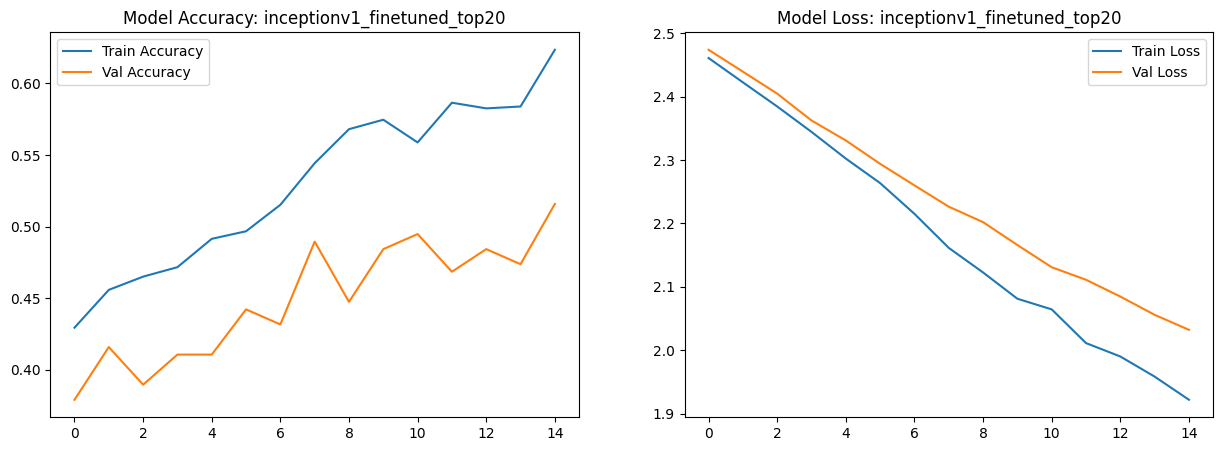

Generating Report...
                                          precision    recall  f1-score   support

                      Audi S6 Sedan 2011       0.78      0.78      0.78         9
       Bentley Continental GT Coupe 2007       0.26      0.67      0.38         9
     Cadillac Escalade EXT Crew Cab 2007       1.00      0.11      0.20         9
             Chevrolet Corvette ZR1 2012       0.54      0.70      0.61        10
             Chevrolet Malibu Sedan 2007       0.75      0.33      0.46         9
                 Chrysler 300 SRT-8 2010       0.31      0.80      0.44        10
                  Dodge Durango SUV 2007       0.33      0.11      0.17         9
              Eagle Talon Hatchback 1998       1.00      0.56      0.71         9
                      Ford GT Coupe 2006       0.55      0.67      0.60         9
                     GMC Savana Van 2012       0.52      0.93      0.67        14
              Geo Metro Convertible 1993       0.64      0.78      0.70     

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json
import os

def evaluate_and_save(model, history, val_loader, class_names, save_name):
    MODELS_PATH = os.path.join(PROJECT_PATH, 'models')
    RESULTS_PATH = os.path.join(PROJECT_PATH, 'results')
    os.makedirs(MODELS_PATH, exist_ok=True)
    os.makedirs(RESULTS_PATH, exist_ok=True)


    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(history['train_acc'], label='Train Accuracy')
    ax[0].plot(history['val_acc'], label='Val Accuracy')
    ax[0].set_title(f'Model Accuracy: {save_name}')
    ax[0].legend()

    ax[1].plot(history['train_loss'], label='Train Loss')
    ax[1].plot(history['val_loss'], label='Val Loss')
    ax[1].set_title(f'Model Loss: {save_name}')
    ax[1].legend()
    plt.savefig(f"{RESULTS_PATH}/{save_name}_curves.png")
    plt.show()


    print("Generating Report...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, zero_division=0)
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))


    torch.save(model.state_dict(), f"{MODELS_PATH}/{save_name}.pth")
    final_data = {"history": history, "report": report_dict}
    with open(f"{RESULTS_PATH}/{save_name}_metrics.json", 'w') as f:
        json.dump(final_data, f)
    print(f"✅ Saved {save_name}")


evaluate_and_save(
    trained_inception,
    inception_history_ft,
    val_loader,
    class_names,
    "inceptionv1_finetuned_top20"
)